In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.qip.circuit import gate_sequence_product, QubitCircuit

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode


# Unitary Circuit

In [2]:
from sync_gates import unitary_circuit

In [3]:
dt = 0.1

detuning = 0.3
signal_strength = 0.2

In [4]:
qc = unitary_circuit(detuning, signal_strength, dt)

p = qc.propagators()
# Doesn't include the measurement or reset
D = gate_sequence_product(p)
D

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.99983751+0.01499869j  0.        +0.j          0.00999983+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99983751+0.01499869j  0.        +0.j
   0.00999983+0.j        ]
 [-0.00999983+0.j          0.        +0.j          0.99983751-0.01499869j
   0.        +0.j        ]
 [ 0.        +0.j         -0.00999983+0.j          0.        +0.j
   0.99983751-0.01499869j]]

## Simulation

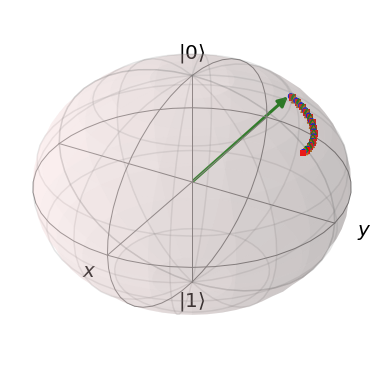

In [5]:
from sync_gates import run_simu

iq_state = (
    3 * np.exp(1j * 1) * basis(2, 0) 
    + np.exp(1j * -np.pi) * basis(2, 1)
).unit()
initial_state = tensor(iq_state, basis(2, 0))

b = Bloch()
b.add_states(initial_state.ptrace(0))

b.add_states([state.ptrace(0) for state in run_simu(qc, 50, initial_state)], kind="point")

b.show()


(<matplotlib.contour.QuadContourSet at 0x222745a87f0>,
 <Figure size 1080x360 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi|\\hat\\rho)$'>))

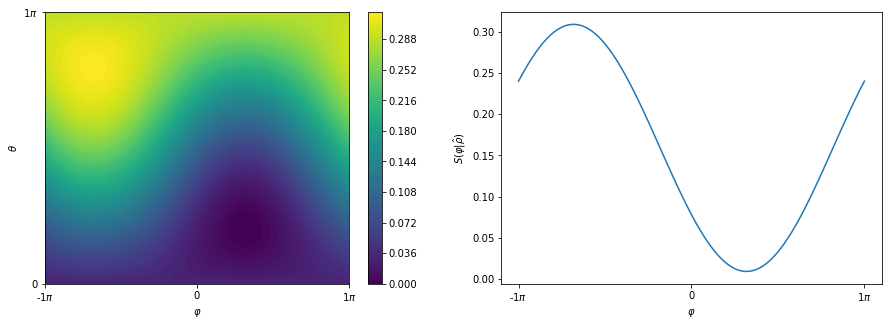

In [6]:
from sync_calcs import spin_husimi_qfunc, spin_S_measure
from sync_plots import plot_Q_and_S

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

Q = spin_husimi_qfunc(initial_state.ptrace(0), theta, phi, method="qutip")
S = spin_S_measure(theta, Q)

plot_Q_and_S(theta, phi, Q.T, S)

# Disipitive Circuit

In [ ]:
from sync_gates import unitary_and_damping_circuit

In [293]:
detuning = 3
signal_strength = 2
dt = 0.3

# Gamma = 0.1
theta_g = 2*np.arcsin(np.sqrt(0.1 * dt))
theta_d = 2*np.arcsin(np.sqrt(1 * dt))

In [294]:
qc = unitary_and_damping_circuit(detuning, signal_strength, dt, theta_d)

# p = qc.propagators()
# # Doesn't include the measurement or reset
# D = gate_sequence_product(p)
# D

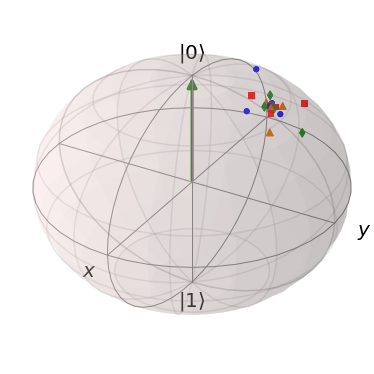

In [295]:
from sync_gates import run_simu

initial_state = tensor(basis(2, 0), basis(2, 0))

b = Bloch()
b.add_states(initial_state.ptrace(0))

states = [state.ptrace(0) for state in run_simu(qc, 100, initial_state)][::]

b.add_states(states, kind="point")

b.show()


In [296]:
# Probabilities
[expect(basis(2,0) * basis(2,0).dag(), states[-1]), expect(basis(2,1) * basis(2,1).dag(), states[-1])]

[0.9185644799321162, 0.08143552006789553]

(<matplotlib.contour.QuadContourSet at 0x2235adc7430>,
 <Figure size 1080x360 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi|\\hat\\rho)$'>))

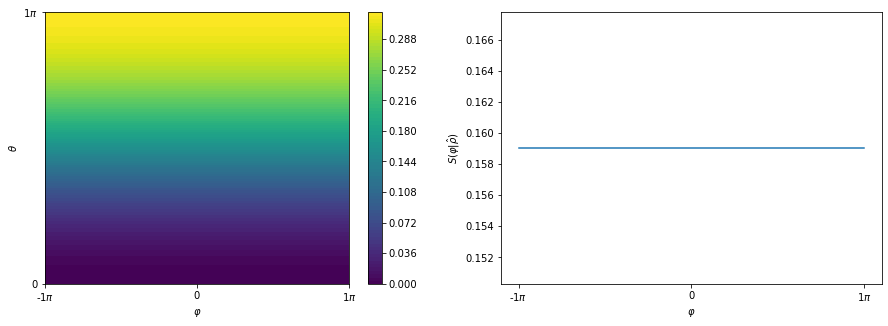

In [297]:
from sync_calcs import spin_husimi_qfunc, spin_S_measure
from sync_plots import plot_Q_and_S

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

Q = spin_husimi_qfunc(initial_state.ptrace(0), theta, phi, method="qutip")
S = spin_S_measure(theta, Q)

plot_Q_and_S(theta, phi, Q.T, S)

# Gain Test

In [298]:
dt = 0.1

detuning = 0.3
signal_strength = 0.2

# Gamma = 0.1
theta_g = 2 * np.arcsin(np.sqrt(0.1 * dt))
theta_d = 2 * np.arcsin(np.sqrt(1 * dt))



In [299]:
from sync_gates import CU, reset

def CUc1t0(args):
    return CU(args, N=3, control=1, target=0)

def CUc1t2(args):
    return CU(args, N=3, control=1, target=2)

In [300]:
qc1 = QubitCircuit(3, user_gates={"CUc1t0": CUc1t0, "CUc1t2": CUc1t2}, num_cbits=1)

phi = gamma = -detuning * dt / 2
theta = -signal_strength * dt
qc1.add_gate("QASMU", arg_value=[theta, phi, gamma], targets=1)

qc1.add_gate("CUc1t0", arg_value=[theta_d, 0, 0])
qc1.add_gate("CNOT", controls=0, targets=1)
qc1.add_measurement("M0", targets=0)

qc2 = QubitCircuit(3, user_gates={"CUc1t0": CUc1t0, "CUc1t2": CUc1t2}, num_cbits=1)
# qc2.add_gate("RX", arg_value=np.pi, targets=2)
qc2.add_gate("CUc1t2", arg_value=[-theta_g, 0, 0])
qc2.add_gate("CNOT", controls=2, targets=1)
qc2.add_measurement("M0", targets=2)


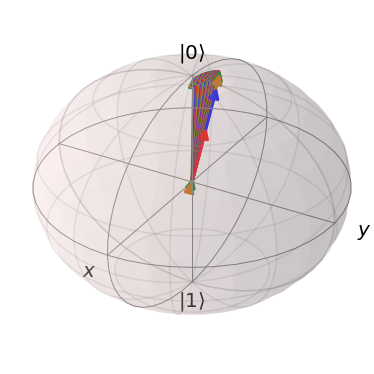

In [301]:
initial_state = tensor(basis(2,0), basis(2,0), basis(2,0))

b = Bloch()

for _ in range(30):
    result1 = qc1.run(state=initial_state)
    reset_result1 = reset(result1, 0, basis(2, 0))

    # initial_state = reset_result1

    result2 = qc2.run(state=reset_result1)
    reset_result2 = reset(result2, 2, basis(2, 0))
    initial_state = reset_result2

    b.add_states(initial_state.ptrace(1))

b.show()

In [302]:
initial_state.ptrace(1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.08900025e-05+0.00000000e+00j -1.37696504e-06-4.68130974e-07j]
 [-1.37696504e-06+4.68130974e-07j  1.96829369e-07+0.00000000e+00j]]

In [303]:
initial_state.ptrace(1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.08900025e-05+0.00000000e+00j -1.37696504e-06-4.68130974e-07j]
 [-1.37696504e-06+4.68130974e-07j  1.96829369e-07+0.00000000e+00j]]